##<b> Importación de librerías necesarias: </b>

In [35]:
import os
import numpy as np
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import datetime

import pandas as pd
import cv2
import glob
import random
import shutil

# Librerias para constuir la arquitectura U-Net
from tensorflow.keras.layers import Input, Lambda, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


##<b> Montaje de unidad Google Drive en el entorno de ejecución: </b>

In [36]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Implementación Proyecto Grado Maestría

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Implementación Proyecto Grado Maestría


##<b> Verificación presencia de GPU: </b>

In [37]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [38]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Dec 13 16:58:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    51W / 400W |    632MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##<b> Carga de dataframe descriptivo del mini-MIAS dataset: </b>

In [39]:
dataPath = "all-mias"
textFile = os.path.join(dataPath,"miasInfo.txt")
mias_df = pd.read_csv(textFile, sep=" ", header=0)
mias_df.head()

#OJO: metadatos de Kaggle están mal. Marcan la mdb212 como anormal (mdb212 G CALC B 687 882 3) y es normal. Puede haber otras mal etiquetadas. OJO
#Usaré los metadatos de: http://peipa.essex.ac.uk/info/mias.html

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb003,D,NORM,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477.0,133.0,30.0


In [40]:
values = {"SEVERITY": 'N', "X": 0, "Y": 0, "RADIUS": 0}
mias_df = mias_df.fillna(value=values)
mias_df.head()

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb003,D,NORM,N,0.0,0.0,0.0
3,mdb004,D,NORM,N,0.0,0.0,0.0
4,mdb005,F,CIRC,B,477.0,133.0,30.0


In [41]:
mias_df.X = mias_df.X.astype(int)
mias_df.Y = mias_df.Y.astype(int)
mias_df.RADIUS = mias_df.RADIUS.astype(int)
mias_df.head()

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535,425,197
1,mdb002,G,CIRC,B,522,280,69
2,mdb003,D,NORM,N,0,0,0
3,mdb004,D,NORM,N,0,0,0
4,mdb005,F,CIRC,B,477,133,30


In [42]:
#Split by class:
benignClass = mias_df[mias_df.SEVERITY=='B']
print("benignClass before balance shape: ", benignClass.shape)

malignantClass = mias_df[mias_df.SEVERITY=='M']
print("malignantClass before balance shape: ", malignantClass.shape)

normalClass = mias_df[mias_df.SEVERITY=='N']
print("normalClass before balance shape: ", normalClass.shape)

benignClass before balance shape:  (67, 7)
malignantClass before balance shape:  (54, 7)
normalClass before balance shape:  (209, 7)


In [43]:
mias_df_2 = pd.concat([benignClass, malignantClass, normalClass])

#Split features and labels:
#Label = mias_df_2.SEVERITY
#Features = mias_df_2.drop(['SEVERITY', 'REFNUM'],axis=1)
#feature_columns = Features.columns

#display("mias_df_2:", mias_df_2.head())
#display("Features:", Features.head())
#display("Label:", Label.head())
print(mias_df_2)

     REFNUM BG CLASS SEVERITY    X    Y  RADIUS
0    mdb001  G  CIRC        B  535  425     197
1    mdb002  G  CIRC        B  522  280      69
4    mdb005  F  CIRC        B  477  133      30
5    mdb005  F  CIRC        B  500  168      26
10   mdb010  F  CIRC        B  525  425      33
..      ... ..   ...      ...  ...  ...     ...
325  mdb318  D  NORM        N    0    0       0
326  mdb319  D  NORM        N    0    0       0
327  mdb320  D  NORM        N    0    0       0
328  mdb321  D  NORM        N    0    0       0
329  mdb322  D  NORM        N    0    0       0

[330 rows x 7 columns]


Detecto las imágenes que son anormales y no están etiquetadas y creo un nuevo dataframe (mias_df_new) sin ellas. También copio todas excepto esas a una nueva carpeta (all-miasPyProc-new(4)). Son 4.

In [44]:
imgs_to_drop_df = mias_df_2[(mias_df_2['SEVERITY'] != 'N') & (mias_df_2['RADIUS'] == 0)]
imgs_to_drop = (imgs_to_drop_df.REFNUM).tolist()
print('imgs_to_drop: ' + str(imgs_to_drop) + '\n')
mias_df_new = mias_df_2.drop(mias_df_2[(mias_df_2['SEVERITY'] != 'N') & (mias_df_2['RADIUS'] == 0)].index)
print(mias_df_new)
#print(mias_df_new.loc[[214]])

imgs_to_drop: ['mdb059', 'mdb216', 'mdb233', 'mdb245']

     REFNUM BG CLASS SEVERITY    X    Y  RADIUS
0    mdb001  G  CIRC        B  535  425     197
1    mdb002  G  CIRC        B  522  280      69
4    mdb005  F  CIRC        B  477  133      30
5    mdb005  F  CIRC        B  500  168      26
10   mdb010  F  CIRC        B  525  425      33
..      ... ..   ...      ...  ...  ...     ...
325  mdb318  D  NORM        N    0    0       0
326  mdb319  D  NORM        N    0    0       0
327  mdb320  D  NORM        N    0    0       0
328  mdb321  D  NORM        N    0    0       0
329  mdb322  D  NORM        N    0    0       0

[326 rows x 7 columns]


In [45]:
#files = glob.glob(dataPath+'/all-miasPythonProcessed/*.png')
#files = glob.glob(dataPath+'/01_allmias_mat_proc_eq/*.png')
files = glob.glob(dataPath+'/allmias_PNG_mat_eq/*.png')


if os.path.isdir(dataPath+'/all-miasPyProc-new(4)') is False:
  os.mkdir(dataPath+'/all-miasPyProc-new(4)')
  for myFile in files:
      basename = os.path.basename(myFile)  # e.g. MyPhoto.jpg
      name = os.path.splitext(basename)[0]  # e.g. MyPhoto
      name = name[:6]
      if (name not in imgs_to_drop):
        shutil.copy(myFile, dataPath+'/all-miasPyProc-new(4)/'+name+'_proc.png')

##<b> Creación de máscara para una imagen: </b>
Se tendrá en cuenta que puede haber más de una anormalidad por imagen

mdb219


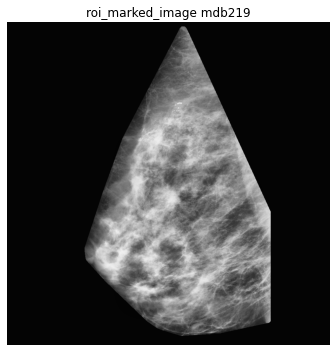

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
221,mdb219,G,CALC,B,546,756,29


In [62]:
#image_path = dataPath+'/allmias_PNG_mat_eq/mdb271_output.png'
image_path = dataPath+'/01_allmias_mat_proc_eq/mdb219_output.png' 

image = cv2.imread(image_path,0) #flag = 0 = cv2.IMREAD_GRAYSCALE
#image_name = image_path[28:34]
image_name = image_path[32:38]
print(image_name)
fig, ax = plt.subplots(figsize=(5,5))

ax.imshow(image, cmap='gray', vmin=0, vmax=255)
ax.set_title("roi_marked_image "+image_name)
ax.axis('off')

plt.tight_layout()
plt.show()

roi_df = mias_df_new.loc[mias_df_new['REFNUM'] == image_name, ['X', 'Y', 'RADIUS']]
#print(roi_df)
roi_values = roi_df.values
height, width = image.shape[:2] #height, width, without number of channels in image

selected_image_df = mias_df_new.loc[mias_df_new['REFNUM'] == image_name]
selected_image_df.head()

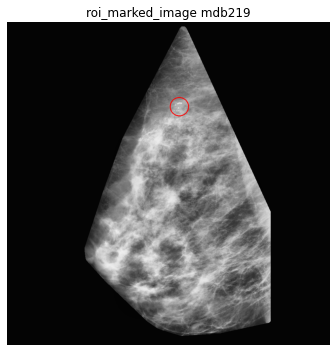

In [63]:
color = 255, 0, 0
thickness = 2 # Line thickness of 2 px

rgb_image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)

for row in roi_values:
    X, Y, RADIUS = row
    Y_new = height - Y
    cv2.circle(rgb_image, (X,Y_new), RADIUS, color, thickness)



fig, ax = plt.subplots(figsize=(5,5))

ax.imshow(rgb_image, vmin=0, vmax=255)
ax.set_title("roi_marked_image "+image_name)
ax.axis('off')

plt.tight_layout()
plt.show()

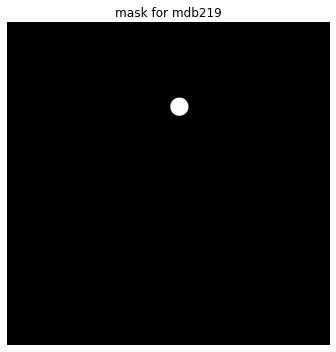

In [14]:
color = 255
zeros_image = np.zeros(image.shape[:2], np.uint8)

for row in roi_values:
    X, Y, RADIUS = row
    Y_new = height - Y
    mask = cv2.circle(zeros_image, (X,Y_new), RADIUS, color, cv2.FILLED)
    #mask = cv2.circle(ones_image, (X,Y_new), RADIUS, color, cv2.FILLED)

fig, ax = plt.subplots(figsize=(5,5))

ax.imshow(mask, cmap='gray', vmin=0, vmax=255)
ax.set_title("mask for "+image_name)
ax.axis('off')

plt.tight_layout()
plt.show()

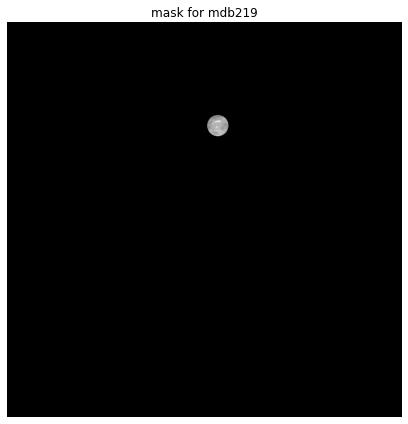

In [15]:
masked_image = cv2.bitwise_and(image,mask)
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(masked_image, cmap='gray', vmin=0, vmax=255)
ax.set_title("mask for "+image_name)
ax.axis('off')
plt.tight_layout()
plt.show()

##<b> Creación de máscaras para todas las mamografías que presenten anormalidades: </b>

Por cada imagen crear una carpeta con dos subcarpetas:

Una carpeta "images" (será all-miasPythonProcessed) con la imagen

Una carpeta "masks" con la máscara o las máscaras binarias

Otra carpeta test con una subcarpeta images dentro la imagen de prueba

Carpeta 	mdb001

Subcarpetas 	images     : mdb001_processed
              masks      : mdb001_processed_mask

In [ ]:
abnormal_imgs_path = (dataPath+'/U-Net_images_masks(4)/train/images/abnormal/')
normal_imgs_path = (dataPath+'/U-Net_images_masks(4)/train/images/normal/')

abnormal_msks_path = (dataPath+'/U-Net_images_masks(4)/train/masks/abnormal/')
normal_msks_path = (dataPath+'/U-Net_images_masks(4)/train/masks/normal/')

if os.path.isdir(abnormal_imgs_path) is False:
  os.makedirs(abnormal_imgs_path)
  os.makedirs(normal_imgs_path)
  os.makedirs(abnormal_msks_path)
  os.makedirs(normal_msks_path)

  abnorm_imgs = []
  abnorm_masks = []
  abnorm_names = []
  norm_imgs = []
  norm_masks = []
  norm_names = []

  #files = glob.glob(dataPath+'/allmias_PNG_mat_eq/*.png')
  files = glob.glob(dataPath+'/all-miasPyProc-new(4)/*.png')
  print('Se crearon las carpetas y files de all-mias py proc new')

  color = 255

  for file_path in files:
      #print(myFile)
      image = cv2.imread(file_path,0)
      #image_name = file_path[28:34]
      basename = os.path.basename(file_path)  # e.g. MyPhoto.jpg
      name = os.path.splitext(basename)[0]  # e.g. MyPhoto
      roi_df = mias_df_new.loc[mias_df_new['REFNUM'] == name[:6], ['X', 'Y', 'RADIUS']]
      roi_values = roi_df.values
      height, width = image.shape[:2] #height, width, without number of channels
      zeros_image = np.zeros(image.shape[:2], np.uint8)
      for row in roi_values:
          X, Y, RADIUS = row
          Y_new = height - Y
          mask = cv2.circle(zeros_image, (X,Y_new), RADIUS, color, cv2.FILLED)
      result = np.all(mask == mask[0])
      if result:
          norm_imgs.append(image)  #print('Los valores son iguales, la máscara es de img normal, no se añade al arreglo')
          norm_masks.append(mask)
          norm_names.append(name)#image_name+'_proc')
      else:
          abnorm_imgs.append(image)
          abnorm_masks.append(mask)
          abnorm_names.append(name)#image_name+'_proc')

  print(len(abnorm_imgs))
  #print(abnorm_names)
  print(len(abnorm_names))
  print(len(norm_imgs))
  print(len(norm_names))

  for abnorm_name, abnorm_image, abnorm_mask in zip(abnorm_names, abnorm_imgs, abnorm_masks):
      cv2.imwrite((dataPath+'/U-Net_images_masks(4)/train/images/abnormal/' + abnorm_name + '.png'), abnorm_image)
      cv2.imwrite((dataPath+'/U-Net_images_masks(4)/train/masks/abnormal/' + abnorm_name + '_mask.png'), abnorm_mask)

  for norm_name, norm_image, norm_mask in zip(norm_names, norm_imgs, norm_masks):
      cv2.imwrite((dataPath+'/U-Net_images_masks(4)/train/images/normal/' + norm_name + '.png'), norm_image)
      cv2.imwrite((dataPath+'/U-Net_images_masks(4)/train/masks/normal/' + norm_name + '_mask.png'), norm_mask)

## Separación imágenes para test
En una sola carpeta llamada test (20% de las imágenes), antes de hacerle augmentation para evitar overfitting.

Teniendo en cuenta que en total, después de todo lo anterior hay:

109 imágenes anormales en train -> 10 se pasan a test -> Quedan 76 en train.

209 imágenes normales en train -> 20 se pasan a test -> Quedan 146 en train.


In [ ]:
#Aquí tengo que escribir las instrucciones para mover el 30% de train abnorm_imgs y train abnorm_masks a test abnorn_imgs y test abnorm_masks:

if os.path.isdir(dataPath+'/U-Net_images_masks(4)/test/images/abnormal/') is False:
  os.makedirs(dataPath+'/U-Net_images_masks(4)/test/images/abnormal/')
  os.makedirs(dataPath+'/U-Net_images_masks(4)/test/masks/abnormal/')
  os.makedirs(dataPath+'/U-Net_images_masks(4)/test/images/normal/')
  os.makedirs(dataPath+'/U-Net_images_masks(4)/test/masks/normal/')

  train_abnorm_imgs = glob.glob(dataPath+'/U-Net_images_masks(4)/train/images/abnormal/*.png')
  train_norm_imgs = glob.glob(dataPath+'/U-Net_images_masks(4)/train/images/normal/*.png')

  #train_images = glob.glob(images_train_path+'*')
  #train_masks = glob.glob(masks_train_path+'*')
  test_abnorm_imgs = random.sample(train_abnorm_imgs, 16) #aprox. 15% de las imágenes para test. (15% y 15%)
  test_norm_imgs = random.sample(train_norm_imgs, 31)
  test_abnorm_msks=[]
  test_norm_msks=[]

  for test_abnorm_img in test_abnorm_imgs:
      index_ab = test_abnorm_img.find('proc')
      index_ab_2 = test_abnorm_img.find('images/')
      test_abnorm_msk = test_abnorm_img[:index_ab+4] + '_mask' + test_abnorm_img[index_ab+4:]
      test_abnorm_msk_2 = test_abnorm_msk[:index_ab_2] + 'masks/' + test_abnorm_msk[index_ab_2+7:]
      test_abnorm_msks.append(test_abnorm_msk_2)

  for test_norm_img in test_norm_imgs:
      index_n = test_norm_img.find('proc')
      index_n_2 = test_norm_img.find('images/')
      test_norm_msk = test_norm_img[:index_n+4] + '_mask' + test_norm_img[index_n+4:]
      test_norm_msk_2 = test_norm_msk[:index_n_2] + 'masks/' + test_norm_msk[index_n_2+7:]
      test_norm_msks.append(test_norm_msk_2)

  print(len(test_abnorm_imgs))
  print(len(test_abnorm_msks))
  print(len(test_norm_imgs))
  print(len(test_norm_msks))

  for test_image, test_mask in zip(test_abnorm_imgs, test_abnorm_msks):
      shutil.move(test_image, dataPath+'/U-Net_images_masks(4)/test/images/abnormal')
      shutil.move(test_mask, dataPath+'/U-Net_images_masks(4)/test/masks/abnormal')

  for test_image, test_mask in zip(test_norm_imgs, test_norm_msks):
      shutil.move(test_image, dataPath+'/U-Net_images_masks(4)/test/images/normal')
      shutil.move(test_mask, dataPath+'/U-Net_images_masks(4)/test/masks/normal')

## Data Augmentation:

Función para generar y guardar el aumento de imágenes:

In [ ]:
def augmentImages(images_paths, dir, imgs_per_image, pixel_fill):
  #images_paths = glob.glob(images_path+'/*.png')

  #Trataré de meter las imágenes a un arreglo para que sean leídas más rápido cuando haga el augmentation:
  imgs_arr=[]
  imgs_names_arr=[]
  for myFile in images_paths:
    image = cv2.imread(myFile)
    imgs_arr.append(image)
    basename = os.path.basename(myFile)  # e.g. MyPhoto.jpg
    name = os.path.splitext(basename)[0]  # e.g. MyPhoto
    imgs_names_arr.append(name)

  for myImage, myName in zip(imgs_arr, imgs_names_arr):
    image = np.expand_dims(myImage,0)
    #min_pixel = np.min(image)
    #min_pixel = 239 #np.max(image)
    #gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.15, height_shift_range=0.15, fill_mode='constant',
    #                          cval=pixel_fill, shear_range=0.15, zoom_range=0.15, horizontal_flip=True)# brightness_range=[0.6,1.3])

    gen = ImageDataGenerator(rotation_range=12, width_shift_range=0.15, height_shift_range=0.15, fill_mode='constant',
                              cval=pixel_fill, shear_range=0.15, horizontal_flip=True)# brightness_range=[0.6,1.3])
    #gen = ImageDataGenerator(width_shift_range=0.15, height_shift_range=0.15, fill_mode='constant',
    #                          cval=min_pixel, shear_range=0.15, zoom_range=0.15, horizontal_flip=True)

    #Save augmented images
    aug_iter = gen.flow(image, save_to_dir=dir, save_prefix='aug_'+myName, save_format='png', seed=1)
    aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(imgs_per_image)]

Lo hago para las anormales, que son menos. Para las de train y las de test:

In [ ]:
#min_pixel = np.min(image)
#max_pixel_img = 239 #np.max(image)
min_pixel_img = 16
min_pixel_msk = 0

#Abnormales para train:

ab_images_train_path = dataPath+'/U-Net_images_masks(4)/train/images/abnormal/'
if len(os.listdir(ab_images_train_path)) == 93:
  train_images_paths = glob.glob(ab_images_train_path+'*.png')
  augmentImages(train_images_paths, ab_images_train_path, 3, min_pixel_img) # actualizar estos números: (x3 aug) Si fueran 4: 78 x 4 = 312, tocaría por 3 porque la 4ta sería la original. Porque 312/2 = 156, si normal = 145 es aprox. 1/3 del total

ab_masks_train_path = dataPath+'/U-Net_images_masks(4)/train/masks/abnormal/'
if len(os.listdir(ab_masks_train_path)) == 93:
  train_masks_paths = glob.glob(ab_masks_train_path+'*.png')
  augmentImages(train_masks_paths, ab_masks_train_path, 3, min_pixel_msk)


#Abnormales para test:

#images_test_path = dataPath+'/U-Net_images_masks(4)/test/images/abnormal/'
#if len(os.listdir(images_test_path)) == 33:
#  test_images_paths = glob.glob(images_test_path+'*.png')
#  augmentImages(test_images_paths, images_test_path, 3, min_pixel_img) #(x3 aug) Si fueran 4: 33 x 4 = 132, tocaría por 3 porque la 4ta sería la original. Porque 132/2 = 66, si normal = 62 es aprox. 1/3 del total

#masks_test_path = dataPath+'/U-Net_images_masks(4)/test/masks/abnormal/'
#if len(os.listdir(masks_test_path)) == 33:
#  test_masks_paths = glob.glob(masks_test_path+'*.png')
#  augmentImages(test_masks_paths, masks_test_path, 3, min_pixel_msk)


#Normales para train: ####################

nor_images_train_path = dataPath+'/U-Net_images_masks(4)/train/images/normal/'
if len(os.listdir(nor_images_train_path)) == 178:
  train_images_paths = glob.glob(nor_images_train_path+'*.png')
  augmentImages(train_images_paths, nor_images_train_path, 2, min_pixel_img) #(x3 aug) Si fueran 4: 78 x 4 = 312, tocaría por 3 porque la 4ta sería la original. Porque 312/2 = 156, si normal = 145 es aprox. 1/3 del total

nor_masks_train_path = dataPath+'/U-Net_images_masks(4)/train/masks/normal/'
if len(os.listdir(nor_masks_train_path)) == 178:
  train_masks_paths = glob.glob(nor_masks_train_path+'*.png')
  augmentImages(train_masks_paths, nor_masks_train_path, 2, min_pixel_msk)


#Normales para test:

#images_test_path = dataPath+'/U-Net_images_masks(4)/test/images/normal/'
#if len(os.listdir(images_test_path)) == 63:
#  test_images_paths = glob.glob(images_test_path+'*.png')
#  augmentImages(test_images_paths, images_test_path, 3, min_pixel_img) #(x3 aug) Si fueran 4: 33 x 4 = 132, tocaría por 3 porque la 4ta sería la original. Porque 132/2 = 66, si normal = 62 es aprox. 1/3 del total

#masks_test_path = dataPath+'/U-Net_images_masks(4)/test/masks/normal/'
#if len(os.listdir(masks_test_path)) == 63:
#  test_masks_paths = glob.glob(masks_test_path+'*.png')
#  augmentImages(test_masks_paths, masks_test_path, 3, min_pixel_msk)

In [ ]:
def remove_surplus(nor_patches_train_path, ab_patches_train_path):
  a = len(os.listdir(nor_patches_train_path))
  b = len(os.listdir(ab_patches_train_path))
  if  a > b:
    dif = a - b
    for c in random.sample(glob.glob(nor_images_train_path+'aug'+'*.png'), dif):
      basename = os.path.basename(c)  # e.g. MyPhoto.jpg
      name = os.path.splitext(basename)[0]
      os.remove(c)
      os.remove(nor_masks_train_path+name[:15]+'_mask'+name[15:]+'.png')
      #print(c)
      #print(nor_masks_train_path+name[:15]+'_mask'+name[15:]+'.png')


print('Antes de remove surplus:')
print(len(os.listdir(nor_images_train_path))) #imprimir cantidad de archivos de carpeta
print(len(os.listdir(ab_images_train_path))) #imprimir cantidad de archivos de carpeta

remove_surplus(nor_images_train_path, ab_images_train_path)

print('\nDespués de remove surplus:')
print(len(os.listdir(nor_masks_train_path))) #imprimir cantidad de archivos de carpeta
print(len(os.listdir(ab_masks_train_path))) #imprimir cantidad de archivos de carpeta

Ahora mezclo normales y anormales en una carpeta ('U-Net_imgs_msks_1_class(4)') para entrenar U-Net con máscaras normales y anormales:

In [ ]:
if os.path.isdir(dataPath+'/U-Net_imgs_msks_1_class(4)/') is False:
  os.makedirs(dataPath+'/U-Net_imgs_msks_1_class(4)/train/images')
  os.makedirs(dataPath+'/U-Net_imgs_msks_1_class(4)/train/masks')
  os.makedirs(dataPath+'/U-Net_imgs_msks_1_class(4)/test/images')
  os.makedirs(dataPath+'/U-Net_imgs_msks_1_class(4)/test/masks')

  abnormal_i_train_path = dataPath+'/U-Net_images_masks(4)/train/images/abnormal/'
  abnormal_m_train_path = dataPath+'/U-Net_images_masks(4)/train/masks/abnormal/'
  normal_i_train_path = dataPath+'/U-Net_images_masks(4)/train/images/normal/'
  normal_m_train_path = dataPath+'/U-Net_images_masks(4)/train/masks/normal/'

  abnormal_i_test_path = dataPath+'/U-Net_images_masks(4)/test/images/abnormal/'
  abnormal_m_test_path = dataPath+'/U-Net_images_masks(4)/test/masks/abnormal/'
  normal_i_test_path = dataPath+'/U-Net_images_masks(4)/test/images/normal/'
  normal_m_test_path = dataPath+'/U-Net_images_masks(4)/test/masks/normal/'

  abnormal_i_train_paths = glob.glob(abnormal_i_train_path+'*.png')
  abnormal_m_train_paths = glob.glob(abnormal_m_train_path+'*.png')
  normal_i_train_paths = glob.glob(normal_i_train_path+'*.png')
  normal_m_train_paths = glob.glob(normal_m_train_path+'*.png')

  abnormal_i_test_paths = glob.glob(abnormal_i_test_path+'*.png')
  abnormal_m_test_paths = glob.glob(abnormal_m_test_path+'*.png')
  normal_i_test_paths = glob.glob(normal_i_test_path+'*.png')
  normal_m_test_paths = glob.glob(normal_m_test_path+'*.png')

  for ab_image, ab_mask in zip(abnormal_i_train_paths, abnormal_m_train_paths):
      shutil.copy(ab_image, dataPath+'/U-Net_imgs_msks_1_class(4)/train/images')
      shutil.copy(ab_mask, dataPath+'/U-Net_imgs_msks_1_class(4)/train/masks')

  for n_image, n_mask in zip(normal_i_train_paths, normal_m_train_paths):
      shutil.copy(n_image, dataPath+'/U-Net_imgs_msks_1_class(4)/train/images')
      shutil.copy(n_mask, dataPath+'/U-Net_imgs_msks_1_class(4)/train/masks')

  for ab_image, ab_mask in zip(abnormal_i_test_paths, abnormal_m_test_paths):
      shutil.copy(ab_image, dataPath+'/U-Net_imgs_msks_1_class(4)/test/images')
      shutil.copy(ab_mask, dataPath+'/U-Net_imgs_msks_1_class(4)/test/masks')

  for n_image, n_mask in zip(normal_i_test_paths, normal_m_test_paths):
      shutil.copy(n_image, dataPath+'/U-Net_imgs_msks_1_class(4)/test/images')
      shutil.copy(n_mask, dataPath+'/U-Net_imgs_msks_1_class(4)/test/masks')

Creo los arreglos de imágenes redimensionadas que van a ir a U-Net:

In [ ]:

imgs_train_path = dataPath+'/U-Net_imgs_msks_1_class(4)/train/images/'
msks_train_path = dataPath+'/U-Net_imgs_msks_1_class(4)/train/masks/'
imgs_test_path = dataPath+'/U-Net_imgs_msks_1_class(4)/test/images/'
msks_test_path = dataPath+'/U-Net_imgs_msks_1_class(4)/test/masks/'

# lista con los archivos dentro de cada carpeta
imgs_train = glob.glob(imgs_train_path+'*.png')
msks_train = glob.glob(msks_train_path+'*.png')
imgs_test = glob.glob(imgs_test_path+'*.png')
msks_test = glob.glob(msks_test_path+'*.png')

# Listas para guardar cada elemento del dataset:
Xtrain = []
Ytrain = []
Xtest = []
Ytest = []

#Listas para guardar nombres correspondientes:
Xtrain_names = []
Ytrain_names = []
Xtest_names = []
Ytest_names = []

width_shape, height_shape = 256, 256 #128, 128 #Tamaño imágenes de entrada
dim = (width_shape, height_shape)

# Recorremos la carpeta train
for image, msk in tqdm(zip(imgs_train, msks_train)):
    img = cv2.imread(image, 1)
    #img = resize(img, (height_shape, width_shape), mode='constant', preserve_range=True)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    # Agrego cada imagen a la lista Xtrain:
    Xtrain.append(img)
    # Agrego cada nombre a la lista Xtrain_names:
    basename = os.path.basename(image)  # e.g. MyPhoto.jpg
    name = os.path.splitext(basename)[0]  # e.g. MyPhoto
    Xtrain_names.append(name)
    # Leo cada una de las mascaras binarias y las redimensiono:
    mask = cv2.imread(msk, 0)
    #mask = resize(mask, (height_shape, width_shape), mode='constant', preserve_range=True)
    mask = cv2.resize(mask, dim, interpolation = cv2.INTER_AREA)
    mask = np.expand_dims(mask, axis=-1)
    # Agrego cada máscara a la lista Ytrain:
    Ytrain.append(mask)
    # Agrego cada nombre a la lista Xtrain_names:
    basename = os.path.basename(msk)  # e.g. MyPhoto.jpg
    name = os.path.splitext(basename)[0]  # e.g. MyPhoto
    Ytrain_names.append(name)

# Recorremos la carpeta test
for image, msk in tqdm(zip(imgs_test, msks_test)):
    img = cv2.imread(image, 1)
    #img = resize(img, (height_shape, width_shape), mode='constant', preserve_range=True)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    # Agrego cada imagen a la lista Xtest:
    Xtest.append(img)
    # Agrego cada nombre a la lista Xtrain_names:
    basename = os.path.basename(image)  # e.g. MyPhoto.jpg
    name = os.path.splitext(basename)[0]  # e.g. MyPhoto
    Xtest_names.append(name)
    # Leo cada una de las mascaras binarias y las redimensiono:
    mask = cv2.imread(msk, 0)
    #mask = resize(mask, (height_shape, width_shape), mode='constant', preserve_range=True)
    mask = cv2.resize(mask, dim, interpolation = cv2.INTER_AREA)
    mask = np.expand_dims(mask, axis=-1)
    # Agrego cada máscara a la lista Ytest
    Ytest.append(mask)
    # Agrego cada nombre a la lista Xtrain_names:
    basename = os.path.basename(msk)  # e.g. MyPhoto.jpg
    name = os.path.splitext(basename)[0]  # e.g. MyPhoto
    Ytest_names.append(name)


X_train = np.asarray(Xtrain,dtype=np.uint8)
print('\nXtrain:',X_train.shape)

Y_train = np.asarray(Ytrain,dtype=bool)
print('Ytrain:',Y_train.shape)

X_test = np.asarray(Xtest,dtype=np.uint8)
print('Xtest:',X_test.shape)

Y_test = np.asarray(Ytest,dtype=bool)
print('Ytest:',Y_test.shape)


In [ ]:
import pickle

with open("X_train(U-Net_det)3b.pkl", "wb") as fp:
  pickle.dump(X_train, fp)
with open("Y_train(U-Net_det)3b.pkl", "wb") as fp:
  pickle.dump(Y_train, fp)
with open("X_test(U-Net_det)3b.pkl", "wb") as fp:
  pickle.dump(X_test, fp)
with open("Y_test(U-Net_det)3b.pkl", "wb") as fp:
  pickle.dump(Y_test, fp)

with open("Xtrain_names(U-Net_det)3b.pkl", "wb") as fp:
  pickle.dump(Xtrain_names, fp)
with open("Ytrain_names(U-Net_det)3b.pkl", "wb") as fp:
  pickle.dump(Ytrain_names, fp)
with open("Xtest_names(U-Net_det)3b.pkl", "wb") as fp:
  pickle.dump(Xtest_names, fp)
with open("Ytest_names(U-Net_det)3b.pkl", "wb") as fp:
  pickle.dump(Ytest_names, fp)

In [ ]:
import pickle

with open("X_train(U-Net_det)3b.pkl", "rb") as fp:
  X_train = pickle.load(fp)
with open("Y_train(U-Net_det)3b.pkl", "rb") as fp:
  Y_train = pickle.load(fp)
with open("X_test(U-Net_det)3b.pkl", "rb") as fp:
  X_test = pickle.load(fp)
with open("Y_test(U-Net_det)3b.pkl", "rb") as fp:
  Y_test = pickle.load(fp)

with open("Xtrain_names(U-Net_det)3b.pkl", "rb") as fp:
  Xtrain_names = pickle.load(fp)
with open("Ytrain_names(U-Net_det)3b.pkl", "rb") as fp:
  Ytrain_names = pickle.load(fp)
with open("Xtest_names(U-Net_det)3b.pkl", "rb") as fp:
  Xtest_names = pickle.load(fp)
with open("Ytest_names(U-Net_det)3b.pkl", "rb") as fp:
  Ytest_names = pickle.load(fp)


print('Xtrain:',X_train.shape)
print('Ytrain:',Y_train.shape)
print('Xtest:',X_test.shape)
print('Ytest:',Y_test.shape)

print('Xtrain_names:',len(Xtrain_names))
print('Ytrain_names:',len(Ytrain_names))
print('Xtest_names:',len(Xtest_names))
print('Ytest_names:',len(Ytest_names))

In [ ]:
index_img = 1
# Imagen y su mascara asociada:
print(Xtrain_names[index_img])
plt.imshow(X_train[index_img])
plt.show()
#plt.imshow(Y_train[0][:,:,0], cmap='gray')
print(Ytrain_names[index_img])
plt.imshow(np.squeeze(Y_train[index_img]), cmap='gray')
plt.show()

print(X_train[index_img].shape)
print(X_train[index_img][:,:,1].shape)
print(Y_train[index_img].shape)
print(np.squeeze(Y_train[index_img]).shape)

## Modelo U-Net:

In [ ]:
# Entrada al modelo:
Image_input = Input((height_shape, width_shape, 3))
Image_in = Lambda(lambda x: x / 255)(Image_input)

#contracting path
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(Image_in)
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
maxp1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(maxp1)
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
maxp2 = MaxPooling2D((2, 2))(conv2)

conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(maxp2)
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
maxp3 = MaxPooling2D((2, 2))(conv3)

conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(maxp3)
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
maxp4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(maxp4)
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

#expansive path
up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
up6 = concatenate([up6, conv4])
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
up7 = concatenate([up7, conv3])
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
up8 = concatenate([up8, conv2])
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
up9 = concatenate([up9, conv1], axis=3)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[Image_input], outputs=[outputs])

#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


#learning_rate = 0.01
#from tensorflow.keras.optimizers import SGD
#sgd = SGD(lr=learning_rate, nesterov=True) #decay=learning_rate, #momentum=0.3, nesterov=True)
#model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

#model.summary()

## Entrenamiento:

In [ ]:
#batch_size = 39 #39 para que sean 8 pasos por epoch porque son 312 imágenes de train = 312/39 = 8
batch_size = 20 #55 para que sean 8 pasos por epoch porque son 220 imágenes de train = 220/55 = 20
epochs = 150 #60

checkpoint_filepath = dataPath+'/tmp/checkpoints'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history_U_Net = model.fit(X_train, Y_train, validation_split=0.15, batch_size=batch_size, epochs=epochs, callbacks=model_checkpoint_callback)

# The model weights (that are considered the best) are loaded into the model.
#model.load_weights(checkpoint_filepath)

Guardo el modelo:

In [ ]:
#model.load_weights(checkpoint_filepath)

#model.save('U-Net_min_val_loss(3b).h5')  # creates a HDF5 file 'my_model.h5'

#del model  # deletes the existing model

# returns a compiled model, identical to the previous one
from keras.models import load_model
model = load_model('U-Net_min_val_loss(3b).h5')

#print(model.summary())







In [ ]:
from keras.callbacks import History
#epochs = 5

# list all data in history
print(history_U_Net.history.keys())
#print(history.history['accuracy'])

# summarize history for accuracy
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, epochs+1, 1), history_U_Net.history['accuracy'])
plt.plot(np.arange(1, epochs+1, 1), history_U_Net.history['val_accuracy'])
#plt.xticks(np.arange(1, epochs+1, 1), list(range(1, epochs+1)))
plt.xlim([0, epochs+1])
plt.title('U-Net accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', framealpha=1)
plt.grid()
plt.show()

# summarize history for loss
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, epochs+1, 1), history_U_Net.history['loss'])
plt.plot(np.arange(1, epochs+1, 1), history_U_Net.history['val_loss'])
#plt.xticks(np.arange(1, epochs+1, 1), list(range(1, epochs+1)))
plt.xlim([0, epochs+1])
plt.title('U-Net loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right', framealpha=1)#, fancybox=True)
plt.grid()
plt.show()

## Prueba con imagen de test:

In [ ]:
preds = model.predict(X_test)

In [ ]:
image_position = 5   #Tener en cuenta la 14 del arreglo de las que tienen anormalidad, la 1 también, la 12 también (revisar 13) #33

print('Mamografía:')
print(X_test.shape)
print(Xtest_names[image_position])
plt.imshow(X_test[image_position], cmap='gray')
plt.show()

print('\nMáscara ground truth:')
print(Y_test.shape)
print(Ytest_names[image_position])
test_masks = Y_test
plt.imshow(np.squeeze(test_masks[image_position]), cmap='gray')
plt.show()
print(test_masks[image_position].min())
print(test_masks[image_position].max())

print('\nMáscara detectada:')
print(preds.shape)
print(preds[image_position].min())
print(preds[image_position].max())
plt.imshow(np.squeeze(preds[image_position]), cmap='gray')
plt.show()


norm_image=cv2.normalize(np.squeeze(preds[image_position]), None, 0, 255, cv2.NORM_MINMAX)
plt.imshow(norm_image, cmap='gray')
plt.show()
print(norm_image.min())
print(norm_image.max())
#print(norm_image)

#Pruebas faltantes:
#Probar con 10% para valid y 10% para test
#Probar entrenar con segmentadas U-Net


In [ ]:
print(Xtest_names)
print(Ytest_names)

In [ ]:
#OJO: Miércoles 16 de noviembre Crear un for para detectar en todas las imágenes de test, guardarlas en carpeta,
#luego acceder a ellas y compararlas con las máscaras GT en la carpeta masks de test con un algoritmo de Jaccard

testtt = (mias_df_new.loc[mias_df_new.REFNUM == name[:6], 'SEVERITY'].values[0])
print(testtt)


name = Ytest_names[image_position]
print(name[:6])
severity = mias_df_new.loc[mias_df_new['REFNUM'] == name[:6], ['SEVERITY']]
print(severity.values[0])

In [ ]:
#print(preds.shape)

test_img_path = dataPath+'/U-Net_imgs_msks_1_class(4)/test_predicted_and_GT(2)/test_imgs/'
test_predicted_path = dataPath+'/U-Net_imgs_msks_1_class(4)/test_predicted_and_GT(2)/test_predicted/'
test_GT_path = dataPath+'/U-Net_imgs_msks_1_class(4)/test_predicted_and_GT(2)/test_GT/'

if os.path.isdir(test_img_path) is False:
   os.makedirs(test_img_path)
   os.makedirs(test_predicted_path)
   os.makedirs(test_GT_path)

   for img, msk_pred, msk_gt, name  in zip(X_test, preds, Y_test, Xtest_names):
       severity = (mias_df_new.loc[mias_df_new.REFNUM == name[:6], 'SEVERITY'].values[0])
       if severity!='N':
          norm_msk_pred = cv2.normalize(msk_pred, None, 0, 255, cv2.NORM_MINMAX)
          cv2.imwrite((test_img_path + name + '.png'), img)
          cv2.imwrite((test_predicted_path + name + '_pred.png'), norm_msk_pred)
          cv2.imwrite((test_GT_path + name + '_GT.png'), msk_gt*255)

In [ ]:
# Test de una imagen cualquiera indicando la ruta:

image_path = dataPath+'/allmias_PNG_mat_eq/mdb132_output.png'
mask_path = dataPath+'/U-Net_imgs_msks_1_class(4)/train/masks/mdb132_proc_mask.png'

#image_path = dataPath+'/U-Net_imgs_msks_1_class(4)/test/images/mdb005_proc.png'
#mask_path = dataPath+'/U-Net_imgs_msks_1_class(4)/test/masks/mdb005_proc_mask.png'

#image_path = dataPath+'/U-Net_images_masks(4)/test/images/normal/mdb260_proc.png' #mdb024
#mask_path = dataPath+'/U-Net_images_masks(4)/test/masks/normal/mdb260_proc_mask.png'

#image_path = dataPath+'/U-Net_imgs_msks_1_class(4)/train/images/mdb012_proc.png'
#mask_path = dataPath+'/U-Net_imgs_msks_1_class(4)/train/masks/mdb012_proc_mask.png'

image = cv2.imread(image_path)
#image_0 = resize(image, (height_shape, width_shape), mode='constant')
#image = resize(image, (height_shape, width_shape), mode='constant', preserve_range=True)
image = cv2.resize(image, (256,256), interpolation = cv2.INTER_AREA)
cv2.imwrite((test_img_path + 'mdb132_proc' + '.png'), image)

mask = cv2.imread(mask_path)
#mask = resize(mask, (height_shape, width_shape), mode='constant', preserve_range=True)
mask = cv2.resize(mask, dim, interpolation = cv2.INTER_AREA)
cv2.imwrite((test_GT_path + 'mdb132_proc' + '_GT.png'), mask)



print('Mamografía:')
print(image_path[45:])
#print(image_path[47:])
plt.imshow(image, cmap='gray')
plt.show()

print('\nGround truth mask:')
print(mask_path[44:])
#print(mask_path[46:])
plt.imshow(mask, cmap='gray')
plt.show()

image = np.expand_dims(image, axis=0)
pred = model.predict(image)
print('\nPredicted mask:')
plt.imshow(np.squeeze(pred), cmap='gray')
plt.show()


norm_msk_pred = cv2.normalize(pred, None, 0, 255, cv2.NORM_MINMAX)
cv2.imwrite((test_predicted_path + 'mdb132_proc' + '_pred.png'), norm_msk_pred)

'''
print('\nBlended image:')
blend_img = cv2.addWeighted(image_0, 1, mask, 0.2, 0)
plt.imshow(np.squeeze(blend_img), cmap='gray')
plt.show()
'''